In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
n_samples = 10000

### Coefficients to find 

In [4]:
w_true = [3,3,3]
w_true = w_true / np.sum(w_true)

In [5]:
mu_true = [3,10,20]

In [6]:
sigma_true = [2,4,1]

### Sampling the distribution

In [7]:
def draw_from_gaussian_mixture(w, mu, sigma, n_samples):
    samples = []
    for i in range(n_samples):
        idx_comp = np.random.multinomial(1,w).argmax()
        samples.append( np.random.randn()*sigma[idx_comp] + mu[idx_comp] )
    return samples

In [8]:
samples = np.array(draw_from_gaussian_mixture(w_true, mu_true, sigma_true, n_samples))

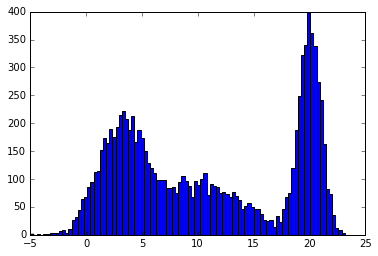

In [9]:
plt.plot(plt.hist(samples, bins=100)[0][0])

In [10]:
from scipy.stats import norm

In [11]:
def plot_gaussian_mixture(w,mu,sigma,color="b"):
    x = np.linspace(-5,30,200)
    y = []
    for i in range(len(x)):
        z = x[i]
        s=0
        for i in range(3):
            s+= norm(loc= mu[i], scale = sigma[i]).pdf(z) * w[i]
        y.append(s)
    plt.plot(x,y, color=color)

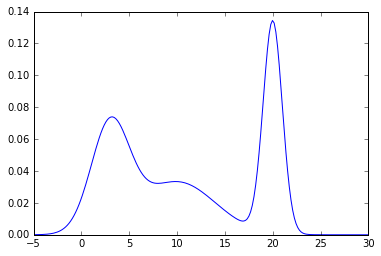

In [12]:
plot_gaussian_mixture(w_true, mu_true, sigma_true)

## Finding coefficients with Tensorflow

In [13]:
import tensorflow as tf

#### Loss function

In [14]:
import math

In [15]:
oneDivSqrtTwoPI = tf.constant(1 / math.sqrt(2*math.pi)) # normalisation factor for gaussian, not needed.
my_epsilon = tf.constant(1e-14)
def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.divide(result,sigma)
    result = -tf.square(result)/2
    return tf.divide(tf.exp(result),sigma)*oneDivSqrtTwoPI

In [16]:
# On utilise un signe moins pour minimiser moins l'entropie

In [17]:
def get_density(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    return result

In [18]:
def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = get_density(out_pi, out_sigma, out_mu, y)
    result = -tf.log(result + my_epsilon) 
    return tf.reduce_mean(result)

In [42]:
def get_mixture_coef(theta):
    out_pi, out_sigma, out_mu = tf.split(theta, num_or_size_splits=3,axis=1)
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.subtract(out_pi, max_pi)
    out_pi = tf.exp(out_pi)
    normalize_pi = tf.divide(out_pi, tf.reduce_sum(out_pi, axis=1, keep_dims=True))
    out_sigma = tf.exp(out_sigma)
    return normalize_pi, out_sigma, out_mu

In [43]:
theta = tf.Variable(tf.random_normal([1,9], stddev=1.0, dtype=tf.float32), name="theta")

In [44]:
out_pi, out_sigma, out_mu = get_mixture_coef(theta)

In [45]:
samples_tf = tf.placeholder(dtype=tf.float32, shape=[None,1], name="samples")

In [46]:
loss = get_lossfunc(out_pi, out_sigma, out_mu, samples_tf)

#### Optimizer

In [47]:
train_op = tf.train.AdamOptimizer(learning_rate=0.05, epsilon=1E-12).minimize(loss)

### Init Session

In [48]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [49]:
def do(x):
    return sess.run(x, feed_dict={samples_tf: samples.reshape(-1,1)})

In [50]:
loss_list = []

In [51]:
sess.run(get_density(out_pi, out_sigma, out_mu, samples_tf), feed_dict={samples_tf: samples.reshape(-1,1)})

array([[  8.95164192e-01],
       [  0.00000000e+00],
       [  0.00000000e+00],
       ..., 
       [  7.58509269e-16],
       [  0.00000000e+00],
       [  1.44748697e-02]], dtype=float32)

In [52]:
for i in range(2000):
    sess.run(train_op, feed_dict={samples_tf:samples.reshape(-1,1)})
    loss_val = sess.run(loss, feed_dict={samples_tf:samples.reshape(-1,1)})
    loss_list.append(loss_val)

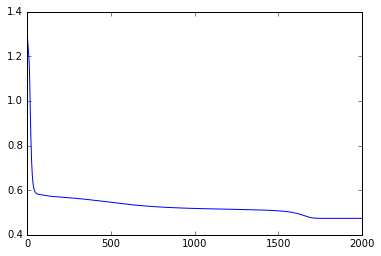

In [53]:
plt.plot(np.log10(loss_list))

In [54]:
out_pi, out_sigma, out_mu = do(get_mixture_coef(theta))

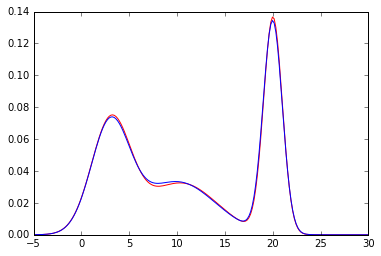

In [55]:
plot_gaussian_mixture(out_pi[0],out_mu[0],out_sigma[0],"r")
plot_gaussian_mixture(w_true, mu_true, sigma_true,"b")

### Commentaires

La densité de probabilité estimée (courbe rouge) ressemble beaucoup à la densité de probabilité que l'on voulait obtenir (courbe bleue).
Mission accomplie !

### Todo

* Le vecteur de paramètres doit être bien initialisé que la densité initiale couvre assez bien tous les échantillons. 
* Faire une fonction pour mieux le paramétrer.
* Utiliser le stochastic gradient descent pour éviter les maxima locaux.